# Trying to align signals using dynamic time warping

In [8]:
import os
from pathlib import Path
import sys
import pandas as pd
from matplotlib import pyplot as plt
from dtw import dtw


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

current_folder = os.getcwd()
print(current_folder)

/Users/opatiny/git/opatiny/predictiveMaintenance/src/notebooks


## Recreate `dtw` example

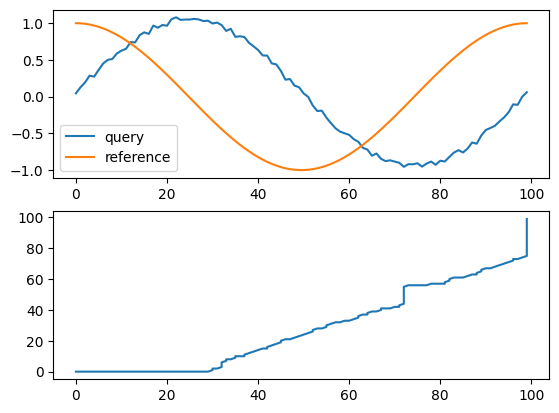

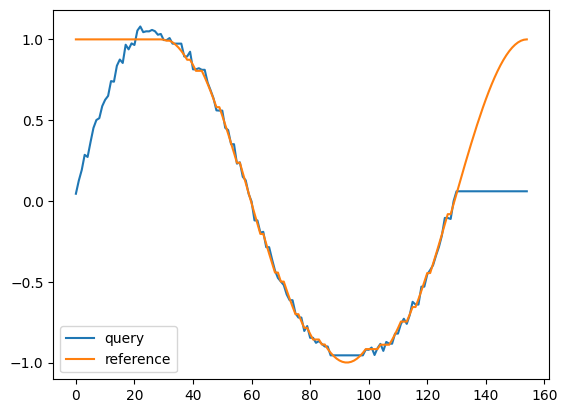

In [ ]:
import numpy as np
from dtw import *
import matplotlib.pyplot as plt

idx = np.linspace(0,6.28,num=100)
query = np.sin(idx) + np.random.uniform(size=100)/10.0
reference = np.cos(idx)
alignment = dtw(query,reference)

# plot query and reference
plt.figure()
plt.subplot(2,1,1)
plt.plot(query, label='query')
plt.plot(reference, label='reference')
plt.legend()
plt.subplot(2,1,2)
plt.plot(alignment.index1, alignment.index2)	

# align both signals
plt.figure()
plt.plot(query[alignment.index1], label='query')
plt.plot(reference[alignment.index2], label='reference')
plt.legend()

## Load some real data

[array([0.0000000e+00, 8.0000000e-04, 1.6000000e-03, ..., 1.6531408e+03,
       1.6531416e+03, 1.6531424e+03], shape=(2065390,)), array([0.0000000e+00, 8.0000000e-04, 1.6000000e-03, ..., 1.6532008e+03,
       1.6532016e+03, 1.6532024e+03], shape=(2065466,)), array([0.0000000e+00, 8.0000000e-04, 1.6000000e-03, ..., 1.6531768e+03,
       1.6531776e+03, 1.6531784e+03], shape=(2065436,))]


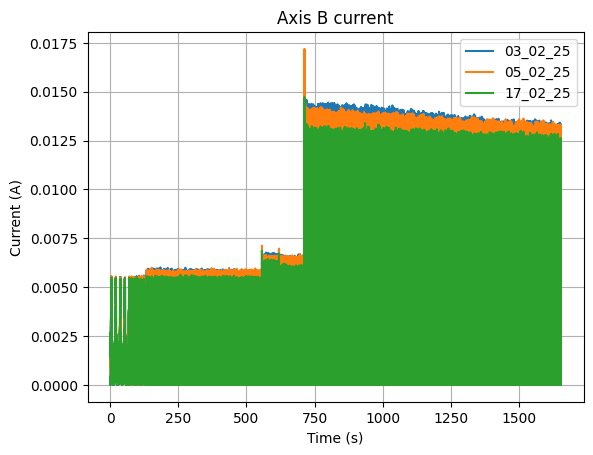

In [30]:
dataPath: Path = "../../data/normalized-2025_05_08/"

machineName = 'Mecatis'

path = os.path.join(current_folder, dataPath)

dates = ['03_02_25', '05_02_25', '17_02_25']

signalName = 'stSigAxCurrentB'

times = []
signals = []

for date in dates:
    sampleName = f'{machineName}_{date}.parquet'
    samplePath = os.path.join(path, sampleName)
    sample = pd.read_parquet(samplePath)

    times.append(sample['timeSeconds'].values)
    signals.append(sample[signalName].values)

print(times)

# plot signals
plt.figure()
# plot all signals in one plot
for i, signal in enumerate(signals):
    plt.plot(times[i], signal, label=dates[i])
plt.legend()

plt.title('Axis B current')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.grid()

## Cut only part of the signals

frequency: 1250.0 Hz
startIndex: 890000, endIndex: 892500


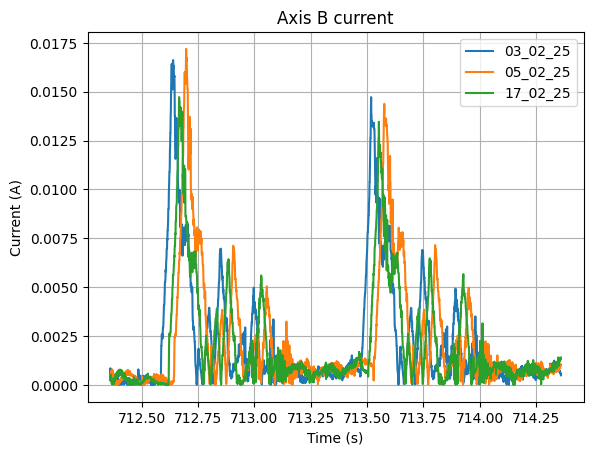

In [32]:
frequency = 1/(times[0][1] - times[0][0]) # seconds

print(f'frequency: {frequency} Hz')

startTime = 712 # seconds
endTime = 714 # seconds

startIndex = int(startTime * frequency)
endIndex = int(endTime * frequency)

print(f'startIndex: {startIndex}, endIndex: {endIndex}')

cutSignals = [signal[startIndex:endIndex] for signal in signals]
cutTimes = [time[startIndex:endIndex] for time in times]


# plot signals
plt.figure()
# plot all signals in one plot
for i in range(len(cutSignals)):
    plt.plot(cutTimes[i], cutSignals[i], label=dates[i])
plt.legend()
plt.title('Axis B current')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.grid()

## Use DTW to align 2 signals

Text(0, 0.5, 'Current (A)')

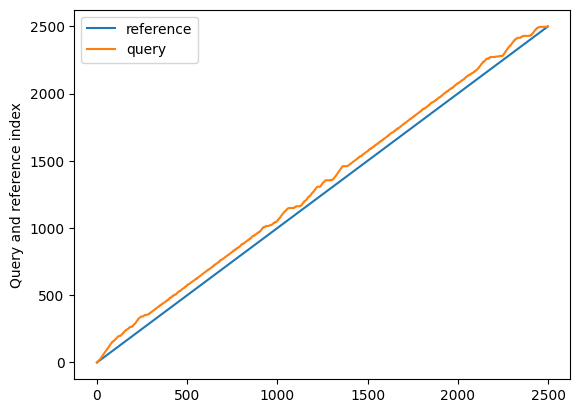

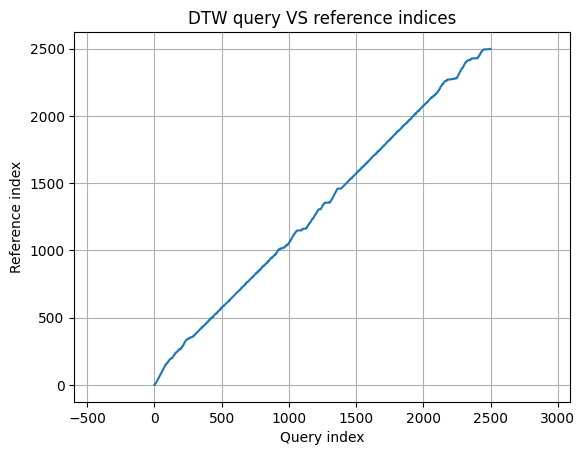

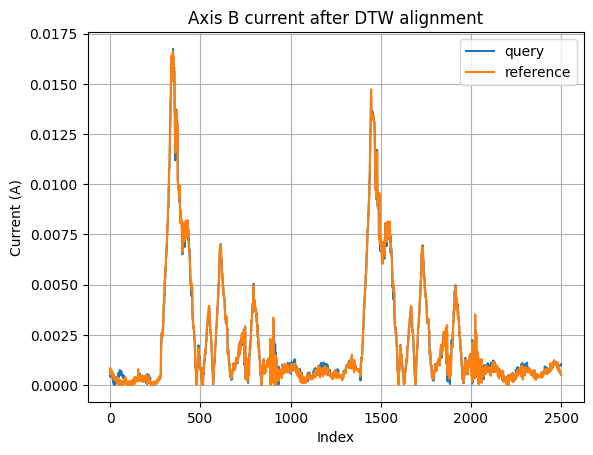

In [53]:
reference = cutSignals[0]
query = cutSignals[1]
alignment = dtw(reference, query, step_pattern="asymmetric")

# plot indices
plt.figure()
plt.plot(alignment.index1)
plt.plot(alignment.index2)
plt.ylabel('Query and reference index')
plt.legend(['reference', 'query'])

# plot alignment   
plt.figure()
plt.plot(alignment.index1, alignment.index2)
plt.title('DTW query VS reference indices')
plt.xlabel('Query index')
plt.ylabel('Reference index')
plt.grid()
plt.axis('equal')

# align both signals
plt.figure()
plt.plot(query[alignment.index2], label='query')
plt.plot(reference, label='reference')
plt.legend()
plt.grid()
plt.title('Axis B current after DTW alignment')
plt.xlabel('Index')
plt.ylabel('Current (A)')


## Align multiple signals on a reference

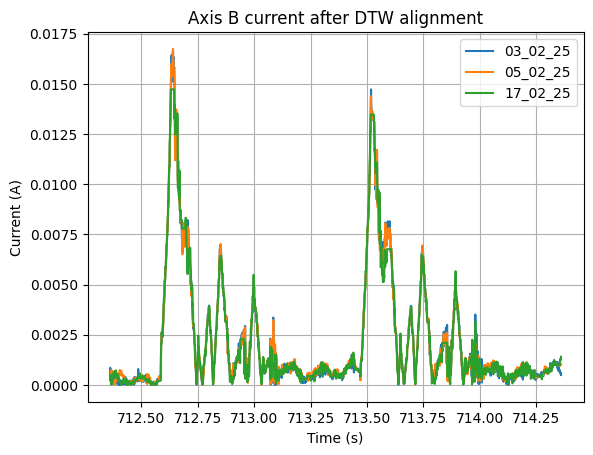

In [57]:
reference = cutSignals[0]
queries = cutSignals[1:]

alignedSignals = [reference]
for query in queries:
    alignment = dtw(reference, query, step_pattern="asymmetric")
    alignedSignals.append(query[alignment.index2])

# plot aligned signals
plt.figure()
# plot all signals in one plot
for i in range(len(alignedSignals)):
    plt.plot(cutTimes[0],alignedSignals[i], label=dates[i])
plt.legend()
plt.title('Axis B current after DTW alignment')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.grid()
